In [1]:
%load_ext autoreload
%autoreload 2

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re
import matplotlib

from skgaip.lung.cyril.lungsim import *

# Cohen waveforms

In [3]:
import os
os.getcwd()

'/home/dsuo/src/skgaip/notebooks'

In [4]:
data_files = glob('../skgaip/lung/cyril/data/no*waveforms.csv')
data = []
metadata = []

def parse_metadata(filename):
    tokens = list(map(int, filter(lambda x: len(x)>0, re.split('[^0-9]', filename))))
    return dict(zip(['C', 'R', 'f', 'PIP', 'PEEP'], tokens[1:]))

for f in data_files:
    df = pd.read_csv(f)
    metadata.append(parse_metadata(f))
    data.append(df[["'control_in'"," 'control_out'"," 'pressure'"," 'timestamp'"]].to_numpy())

# Breath Waveform explainer

In [89]:
# TBD

# Proxy control signal explainer

In [5]:
valve = ValveCurve('../skgaip/lung/cyril/data/valve_response_bidir.csv')

# Current controller

In [230]:
def plot(i, T=2000, raw_control_in=False, control_in_delay=None, figsize=(16,5.5), ylim=(0, 70), title=True, pressure_only=False):
    plt.rc('figure', figsize=figsize)
    control_in, control_out, pressure, tt = data[i][:T].T
    tt = tt - min(tt)
    
    control_in_label = "Control signal"
    if not raw_control_in:
        control_in = valve.at(np.clip(control_in, 0, 100))
        control_in_label = "Control signal (% PIP valve open)"
    
    fig, ax1 = plt.subplots()
    delay = 1
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Pressure (mm Hg)")
    ax1.set_ylim(*ylim)
    tube_pressure = ax1.plot(tt[:-delay], pressure[delay:], c='rygbm'[i], label="Rel. tube pressure (mm Hg)")
    pip = ax1.axhline(metadata[i]['PIP'], ls='--', c='k', label="PIP (mm Hg)")
    peep = ax1.axhline(metadata[i]['PEEP'], ls=':', c='k', label="PEEP (mm Hg)")
    ax1.fill_between(tt, plt.ylim()[0], plt.ylim()[1], where=control_out.astype(bool), color='lightgray', alpha=0.3)
    
    if not pressure_only:
        ax2 = ax1.twinx()
        ax2.set_ylabel(control_in_label)
        if control_in_delay is not None:
            control_delay = ax2.plot(tt + control_in_delay, control_in, c='rygbm'[i], ls="--", label="Delayed control signal")
        control = ax2.plot(tt, control_in, c='gray', label=control_in_label)

    if title:
        plt.title("Breath cycle with compliance {}, resistance {}, flow {}".format(metadata[i]["C"], metadata[i]["R"], metadata[i]["f"]))
    
    lines = [tube_pressure[0], pip, peep]
    if not pressure_only:
        lines.append(control[0])
        if control_in_delay is not None:
            lines.append(control_delay[0])
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper right")


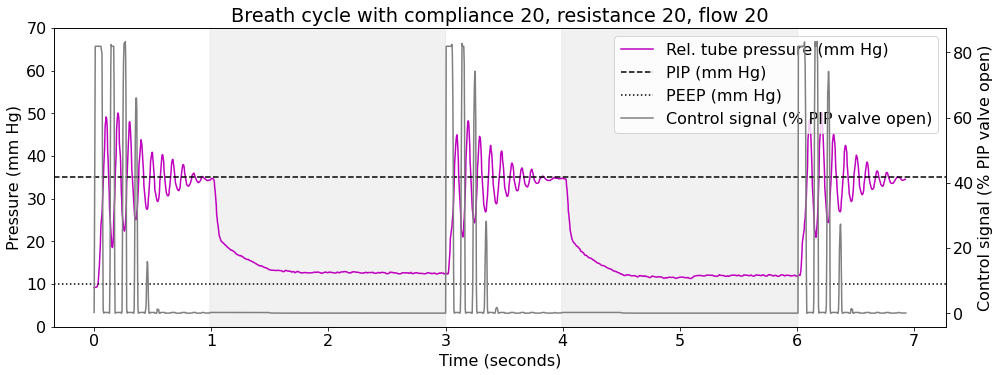

In [231]:
plot(4)

In [140]:
metadata[0]

{'C': 20, 'R': 5, 'f': 20, 'PIP': 30, 'PEEP': 5}

In [ ]:
from datetime import datetime
datetime.now().timestamp()

# Existing simulator

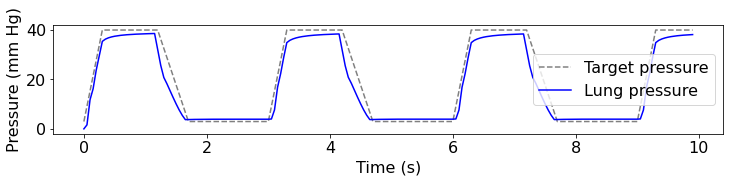

In [105]:
# track waveform from demo
plt.rc('figure', figsize=(12, 2))

T = 10     # simulation length in real time
dt = 0.05  # time discretization
tt = np.arange(T // dt) * dt

# environment: lung physics + target waveform
lung = DemoLung(leak=False, peep_valve=5, PC=40, RP=1, dt=dt)
target = BreathWaveform([3, 40], [0.3, 1.2, 1.7, 3])

# control policy
pid = PID([3, 4, 0], dt=dt) # example code uses hand-tuned time-varying PID

for t in tt:
  err = target.at(t) - lung.current_pressure
  pip = pid.feed(err)
  peep = int(t % 3.0 > 1.2) # like example code, use breath phase to control peep
  lung.step(pip, peep)

plt.xlabel("Time (s)")
plt.ylabel("Pressure (mm Hg)")
plt.plot(tt, target.at(tt), c='gray', ls='--', label="Target pressure")
plt.plot(tt, lung.pressures, c='b', label="Lung pressure")
plt.legend()

# Delay

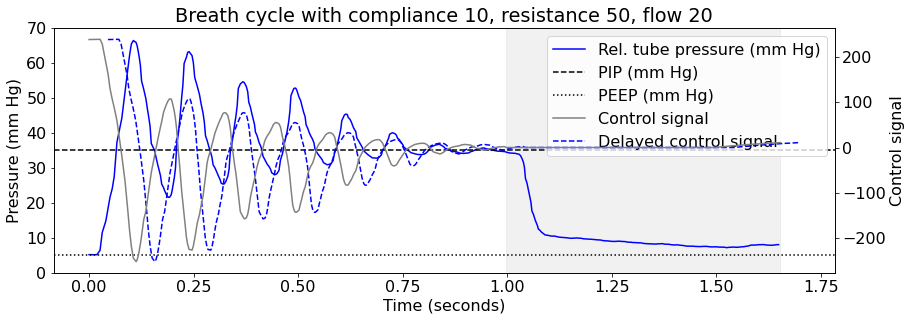

In [165]:
plot(i, T=500, raw_control_in=True, control_in_delay=0.045, figsize=(14, 4.5))

# Updated simulator

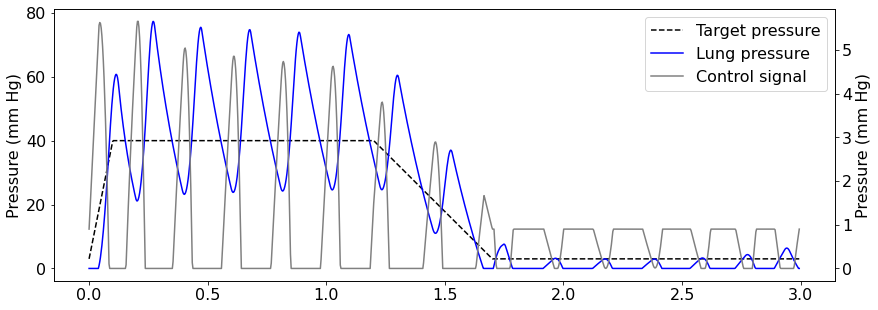

In [196]:
plt.rc('figure', figsize=(14,5))

for i,K_P in enumerate([0.3]):
    ax1 = plt.subplot(111+i)
    
    # track waveform
    T = 3     # simulation length in real time
    dt = 0.003  # time discretization
    tt = np.arange(T // dt) * dt

    # environment: lung physics + target waveform
    lung = DelayLung()
    target = BreathWaveform([3, 40], [0.1, 1.2, 1.7, 3])

    # control policy
    pid = PID([K_P, 0, 0], dt=dt)

    prev_u = 0

    for t in tt:
      err = target.at(t) - lung.pressure
      u = pid.feed(err)
      prev_u = u
      peep = int(t % 3.0 > 1.2)
      lung.step(u, peep)

    target_pressure = ax1.plot(tt, target.at(tt), c='k', ls='--', label="Target pressure")
    lung_pressure = ax1.plot(tt, lung.pressures, c='b', label="Lung pressure")
    ax1.set_ylabel("Pressure (mm Hg)")
    
    ax2 = ax1.twinx()
    control = ax2.plot(tt, lung.controls_in, c='gray', label="Control signal")
    ax2.set_ylabel("Pressure (mm Hg)")
    
#     ax2.set_ylabel(control_in_label)
#     if control_in_delay is not None:
#         control_delay = ax2.plot(tt + control_in_delay, control_in, c='rygbm'[i], ls="--", label="Delayed control signal")
#     control = ax2.plot(tt, control_in, c='gray', label=control_in_label)

#     plt.title("Breath cycle with compliance {}, resistance {}, flow {}".format(metadata[i]["C"], metadata[i]["R"], metadata[i]["f"]))
    
    lines = [target_pressure[0], lung_pressure[0], control[0]]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc=0)

#     plt.twinx().plot(tt, lung.controls_in, c='gray')


# Before

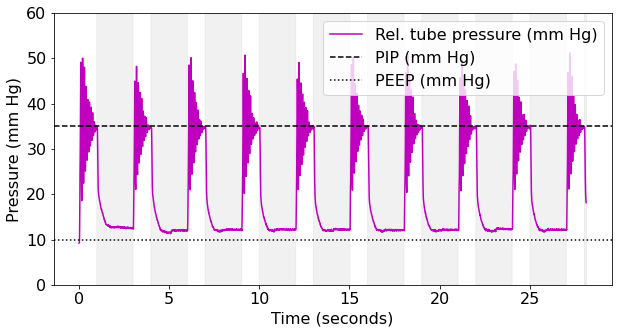

In [232]:
plot(4, T=8000, raw_control_in=True, figsize=(10,5), ylim=(0, 60), title=False, pressure_only=True)